# Pregunta 1. Implementar un sistema experto usando CLIPSPY

He deidido desarrollar un sistema experto en **turismo** que a partir de los intereses del usuario recomienda diferentes destinos posibles para viajar.

El sistema parte de la base de que el usuario se encuentra ubicado en Mallorca. Es por eso que el campo "flight_time" toma como referencia la isla para decidir la distancia de los destinos.

Para un sistema real lo ideal sería utilizar una API de mapas para poder preguntar la ubicación del usuario y a partir de ahí se podría definir cuáles son los destinos cercanos o lejanos.

In [2]:
pip install clipspy

In [1]:
def validate_preferences(weather, activity, max_budget, flight_time, days_available, group_type):
    weather = weather.strip().lower()
    activity = activity.strip().lower()
    flight_time = flight_time.strip().lower()
    group_type = group_type.strip().lower()

    valid_weather = ['cálido', 'templado', 'frío', 'indiferente']
    valid_flight_times = ['corto', 'largo', 'indiferente']
    valid_activities = ['playa', 'cultura', 'aventura', 'naturaleza', 'gastronomía']
    valid_group_types = ['solo', 'familia', 'pareja', 'amigos']
    if weather not in valid_weather:
        raise ValueError(f'El clima debe ser uno de {valid_weather}, pero se recibió: {weather}.')
    if activity not in valid_activities:
        raise ValueError(f'La actividad debe ser una de {valid_activities}, pero se recibió: {activity}.')
    if flight_time not in valid_flight_times:
        raise ValueError(f'El tiempo de vuelo debe ser uno de {valid_flight_times}, pero se recibió: {flight_time}.')
    if days_available <= 0:
        raise ValueError(f'La disponibilidad de días debe ser un número positivo, pero se recibió: {days_available}.')
    if group_type not in valid_group_types:
        raise ValueError(f'El tipo de grupo debe ser uno de {valid_group_types}, pero se recibió: {group_type}.')


In [3]:
from clips import Environment, Symbol

TEMPLATE_STRING = '''
(deftemplate preferences
    (slot weather (type SYMBOL))
    (slot activity (type SYMBOL))
    (slot max_budget (type INTEGER))
    (slot flight_time (type SYMBOL))
    (slot group_type (type SYMBOL))
    (slot days_available (type INTEGER))
)
'''

TEMPLATE_RECOMMENDATION = '''
(deftemplate recommendation
    (slot destination (type STRING))
    (slot description (type STRING))
)
'''

RULE_BEACH = '''
(defrule beach
    "Recomendar destinos cálidos con playas dentro del presupuesto."
    (preferences (weather cálido)
                 (activity playa)
                 (max_budget ?max)
                 (flight_time corto|indiferente)
                 (group_type solo|pareja|amigos|familia)
                 (days_available ?days))
    =>
    (if (and (>= ?days 2) (<= ?days 7))
        then
            (if (and (>= ?max 200) (< ?max 500))
                then
                    (assert (recommendation (destination "Menorca")
                                            (description "Playas cálidas y aguas cristalinas."))))
            (if (>= ?max 500)
                then
                    (assert (recommendation (destination "Ibiza")
                                            (description "Playas espectaculares y vida nocturna animada.")))
                    (assert (recommendation (destination "Formentera")
                                            (description "Playas paradisíacas y ambiente tranquilo.")))))
)
'''

RULE_CULTURAL = '''
(defrule cultural
    "Recomendar destinos culturales dentro del presupuesto."
    (preferences (weather cálido|templado|indiferente)
                 (activity cultura)
                 (max_budget ?max)
                 (flight_time corto|indiferente)
                 (group_type solo|pareja|familia)
                 (days_available ?days))
    =>
    (if (and (>= ?days 3) (<= ?days 6))
        then
            (if (>= ?max 400)
                then
                    (assert (recommendation (destination "Toledo")
                                            (description "Ciudad histórica llena de cultura y arte.")))
                    (assert (recommendation (destination "Granada")
                                            (description "La Alhambra y un legado cultural incomparable."))))
            (if (>= ?max 600)
                then
                    (assert (recommendation (destination "Sevilla")
                                            (description "Maravillosa ciudad con monumentos icónicos y bunea música flamenca.")))
                    (assert (recommendation (destination "Córdoba")
                                            (description "La Mezquita y una rica historia cultural.")))))
)
'''


RULE_ADVENTURE = '''
(defrule adventure
    "Recomendar destinos de aventura y naturaleza dentro del presupuesto."
    (preferences (weather ?w)
                 (activity aventura)
                 (max_budget ?max)
                 (flight_time largo|indiferente)
                 (group_type solo|pareja|amigos)
                 (days_available ?days))
    =>
    (if (and (>= ?days 7) (<= ?days 15) (>= ?max 900))
        then
            (if (eq ?w cálido)
                then
                    (assert (recommendation (destination "Costa Rica")
                                            (description "Selvas tropicales y deportes extremos.")))
                    (assert (recommendation (destination "Perú")
                                            (description "Montañas, selvas y ruinas históricas como Machu Picchu.")))
            )
            (if (eq ?w frío)
                then
                    (assert (recommendation (destination "Islandia")
                                            (description "Glaciares, cascadas y paisajes surrealistas.")))
                    (assert (recommendation (destination "Noruega")
                                            (description "Fiordos, montañas y aventuras en un clima frío.")))
            )
            (if (eq ?w indiferente)
                then
                    (assert (recommendation (destination "Costa Rica")
                                            (description "Selvas tropicales y deportes extremos.")))
                    (assert (recommendation (destination "Perú")
                                            (description "Montañas, selvas y ruinas históricas como Machu Picchu.")))
                    (assert (recommendation (destination "Islandia")
                                            (description "Glaciares, cascadas y paisajes surrealistas.")))
                    (assert (recommendation (destination "Noruega")
                                            (description "Fiordos, montañas y aventuras en un clima frío.")))
            )
    )
)
'''

RULE_FOOD = '''
(defrule food
    "Recomendar destinos gastronómicos."
    (preferences (activity gastronomía)
                 (max_budget ?max)
                 (group_type ?type)
                 (days_available ?days))
    =>
    (if (and (>= ?max 500) (>= ?days 3) (<= ?days 7)
             (or (eq ?type familia) (eq ?type pareja)))
        then
            (assert (recommendation (destination "San Sebastián")
                                    (description "Capital gastronómica con pintxos y mariscos."))))
    (if (and (>= ?max 600) (>= ?days 3) (<= ?days 10)
             (or (eq ?type pareja) (eq ?type amigos) (eq ?type solo)))
        then
            (assert (recommendation (destination "Lyon")
                                    (description "Cuna de la cocina francesa."))))
)
'''

RULE_LUXURY = '''
(defrule luxury
    "Recomendar destinos de lujo para presupuestos altos."
    (preferences (max_budget ?max)
                 (flight_time largo|indiferente)
                 (group_type ?type)
                 (days_available ?days))
    =>
    (if (and (>= ?max 3000) (>= ?days 7) (<= ?days 15))
        then
            (if (or (eq ?type pareja) (eq ?type familia) (eq ?type amigos))
                then
                    (assert (recommendation (destination "Maldivas")
                                            (description "Resorts privados sobre el agua.")))
                    (assert (recommendation (destination "Suiza")
                                            (description "Paisajes alpinos, lujo y relojes suizos.")))
            )
            (if (or (eq ?type solo) (eq ?type pareja))
                then
                    (assert (recommendation (destination "Dubái")
                                            (description "Lujo, rascacielos y experiencias exclusivas.")))
                    (assert (recommendation (destination "Tokio")
                                            (description "Lujo, rascacielos y cultura asiática.")))r))
)
'''

### Cargar las reglas en el entorno:
env = Environment()
env.build(TEMPLATE_STRING)
env.build(TEMPLATE_RECOMMENDATION)
env.build(RULE_BEACH)
env.build(RULE_CULTURAL)
env.build(RULE_ADVENTURE)
env.build(RULE_FOOD)
env.build(RULE_LUXURY)

print('- Bienvenido al Sistema Experto de Turismo -')
print('Por favor, completa tus preferencias a continuación:')

try:
    weather_options = ['cálido', 'templado', 'frío', 'indiferente']
    activity_options = ['playa', 'cultura', 'aventura', 'gastronomía']
    flight_time_options = ['corto', 'largo', 'indiferente']
    group_type_options = ['solo', 'familia', 'pareja', 'amigos']

    weather = input(f'¿Qué tipo de clima prefieres? (opciones: {", ".join(weather_options)}): ').strip()
    activity = input(f'¿Qué actividad prefieres? Escoge una (opciones: {", ".join(activity_options)}): ').strip()
    max_budget = int(input('¿Cuál es tu presupuesto máximo (en euros)?: '))
    flight_time = input(f'¿Prefieres que sea un vuelo corto o largo? (opciones: {", ".join(flight_time_options)}): ').strip()
    group_type = input(f'¿Viajas solo o con más gente? (opciones: {", ".join(group_type_options)}): ').strip()
    days_available = int(input('¿Cuántos días de disponibilidad tienes para el viaje?: '))

    validate_preferences(weather, activity, max_budget, flight_time, days_available, group_type)

    template = env.find_template('preferences')
    fact = template.assert_fact(
        weather=Symbol(weather),
        activity=Symbol(activity),
        max_budget=max_budget,
        flight_time=Symbol(flight_time),
        group_type=Symbol(group_type),
        days_available=days_available
    )
    print(f"Se han registrado tus preferencias: {fact}")

    print('\nAquí tienes tus recomendaciones de viaje:')
    env.run()

    recommendations = env.facts()
    found_recommendations = False
    for recommendation in recommendations:
        if recommendation.template.name == 'recommendation':
            destination = recommendation['destination']
            description = recommendation['description']
            print(f"- {destination}: {description}")
            found_recommendations = True

    if not found_recommendations:
        print("No se encontraron recomendaciones para tus preferencias.")

except ValueError as e:
    print(f'Error: {e}')


- Bienvenido al Sistema Experto de Turismo -
Por favor, completa tus preferencias a continuación:
¿Qué tipo de clima prefieres? (opciones: cálido, templado, frío, indiferente): templado
¿Qué actividad prefieres? Escoge una (opciones: playa, cultura, aventura, gastronomía): gastronomía
¿Cuál es tu presupuesto máximo (en euros)?: 500
¿Prefieres que sea un vuelo corto o largo? (opciones: corto, largo, indiferente): corto
¿Viajas solo o con más gente? (opciones: solo, familia, pareja, amigos): pareja
¿Cuántos días de disponibilidad tienes para el viaje?: 3
Se han registrado tus preferencias: (preferences (weather templado) (activity gastronomía) (max_budget 500) (flight_time corto) (group_type pareja) (days_available 3))

Aquí tienes tus recomendaciones de viaje:
- San Sebastián: Capital gastronómica con pintxos y mariscos.


# Pregunta 2. Resolver un problema de ARC Prize

In [4]:
import numpy as np

# Simulamos los 3 grids de ejemplo más el de test
shadow_grid_ex_1 = np.array([[0,2,0,0,4],
                            [0,0,0,0,0],
                            [0,0,0,0,0],
                            [0,2,3,0,0],
                            [1,0,0,0,0]
                          ])

shadow_grid_ex_2 = np.array([[0,0,0,0,4],
                            [0,0,0,6,0],
                            [2,0,0,0,0],
                            [2,0,5,6,0],
                            [2,0,5,0,0],
                          ])

shadow_grid_ex_3 = np.array([[0,0,0,1,0],
                            [0,7,0,0,0],
                            [0,7,0,1,5],
                            [3,0,0,0,0],
                            [0,7,0,0,0],
                          ])

shadow_grid_test = np.array([[0,5,0,2,7],
                            [8,0,0,0,0],
                            [0,0,3,0,0],
                            [8,5,0,2,0],
                            [8,0,0,0,0],
                          ])

In [5]:
# Mueve las piezas hacia abajo
def move_piece_down(grid):
  rows,cols=grid.shape
  modified_grid = grid.copy()
  for r in range(rows-1):
    for c in range(cols):
      if modified_grid[r,c]!=0 and modified_grid[r+1,c]==0:
        modified_grid[r+1,c]=modified_grid[r,c]
        modified_grid[r,c]=0
  return modified_grid

# Comprueba si es posible mover más piezas
def is_possible_to_move_more_pieces(modified_grid):
  rows,cols=modified_grid.shape
  for r in range(rows-1):
    for c in range(cols):
      if modified_grid[r,c]!=0 and modified_grid[r+1,c]==0:
        return True
  return False

# Encuentra la solución de cada grid
def find_grid_solution(grid):
  solved_grid = grid.copy()
  while is_possible_to_move_more_pieces(solved_grid):
    solved_grid = move_piece_down(solved_grid)
  return solved_grid


In [6]:
# Iteramos sobre los posibles grids y llamamos a la función imprimiendo la respuesta
grids = [shadow_grid_ex_1, shadow_grid_ex_2, shadow_grid_ex_3, shadow_grid_test]

for i, grid in enumerate(grids, 1):
  solution = find_grid_solution(grid)
  print(f"Grid {i} solved:")
  print(solution)
  print("\n")

Grid 1 solved:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 2 0 0 0]
 [1 2 3 0 4]]


Grid 2 solved:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [2 0 0 0 0]
 [2 0 5 6 0]
 [2 0 5 6 4]]


Grid 3 solved:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 7 0 0 0]
 [0 7 0 1 0]
 [3 7 0 1 5]]


Grid 4 solved:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [8 0 0 0 0]
 [8 5 0 2 0]
 [8 5 3 2 7]]




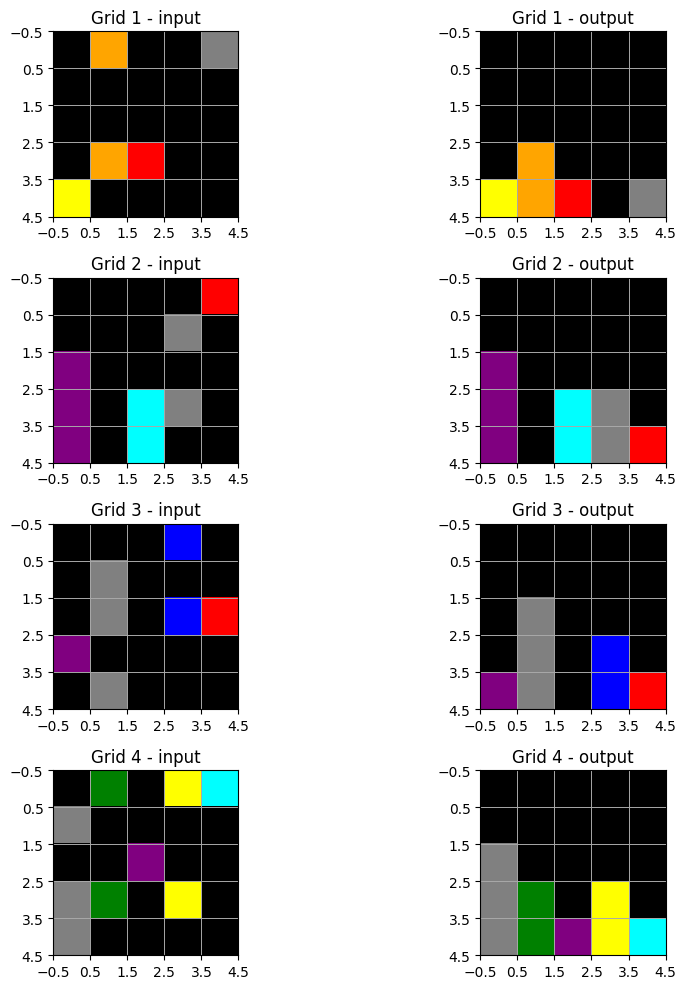

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ['black', 'blue', 'yellow', 'purple', 'orange', 'green', 'red', 'cyan', 'gray']
cmap = ListedColormap(colors)

def plot_multiple_grids(grids):
    fig, axs = plt.subplots(4, 2, figsize=(10, 10))

    for i in range(4):
        # Input
        axs[i, 0].imshow(grids[2 * i], cmap=cmap)
        axs[i, 0].set_title(f"Grid {i+1} - input")
        axs[i, 0].set_xticks(np.arange(-0.5, grids[2 * i].shape[1], 1), minor=False)
        axs[i, 0].set_yticks(np.arange(-0.5, grids[2 * i].shape[0], 1), minor=False)
        axs[i, 0].grid(True, which="both", color="darkgray", linestyle="-", linewidth=0.7)
        axs[i, 0].set_aspect('equal')

        # Output
        axs[i, 1].imshow(grids[2 * i + 1], cmap=cmap)
        axs[i, 1].set_title(f"Grid {i+1} - output")
        axs[i, 1].set_xticks(np.arange(-0.5, grids[2 * i + 1].shape[1], 1), minor=False)
        axs[i, 1].set_yticks(np.arange(-0.5, grids[2 * i + 1].shape[0], 1), minor=False)
        axs[i, 1].grid(True, which="both", color="darkgray", linestyle="-", linewidth=0.7)
        axs[i, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

# Como en el bloque de código anterior, iteramos sobre los posibles grids y llamamos a la función imprimiendo la respuesta
grids_input = [shadow_grid_ex_1, shadow_grid_ex_2, shadow_grid_ex_3, shadow_grid_test]
grids_output = []
combined_grids = []

for i, grid in enumerate(grids_input, 1):
    solved_grid = find_grid_solution(grid)

    if np.any(solved_grid):
        grids_output.append(solved_grid)
    else:
        grids_output.append(np.zeros(grid.shape))
        print(f"No se ha encontrado la solución del grid {i}\n")

for grid_input, output in zip(grids_input, grids_output):
    combined_grids.append(grid_input)
    combined_grids.append(output)

# Llamamos a la función para mostrar los grids
plot_multiple_grids(combined_grids)